In [2]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import (
    CatBoostClassifierModel,
)

In [5]:
data_dir = "/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data"
fpaths = []
for el in os.walk(data_dir):
    for fname in el[2]:
        fpaths.append(os.path.join(data_dir, fname))

In [7]:
covs = []
series = []

for idx, fpath in enumerate(fpaths):
    print(fpath)
    arr = np.load(fpath)
    xs = arr["x"]
    ys = arr["y"]

    n_steps = xs.shape[1]
    times = pd.date_range(
        "2000-01-01",
        periods=xs.shape[0] * xs.shape[1],
        freq="20ms",
    )
    y = [y_i for y_i in ys for _ in range(n_steps)]

    cov_ = TimeSeries.from_times_and_values(
        times=times,
        values=xs.flatten(),
    )
    series_ = TimeSeries.from_times_and_values(
        times=times,
        values=y,
        static_covariates=pd.DataFrame({"name": [idx]}),
        metadata={"name": idx},
    )

    cov_ = cov_.resample("1s")
    series_ = series_.resample("1s")

    covs.append(cov_)
    series.append(series_)

/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4182E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4062E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4142E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4001E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4121E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4101E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4021E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4162E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4082E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4042E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC4061E0.npz
/Users/dennisbader/projects/unit8/darts_test_code/cat_forecasting/data/SC418

<Axes: xlabel='time'>

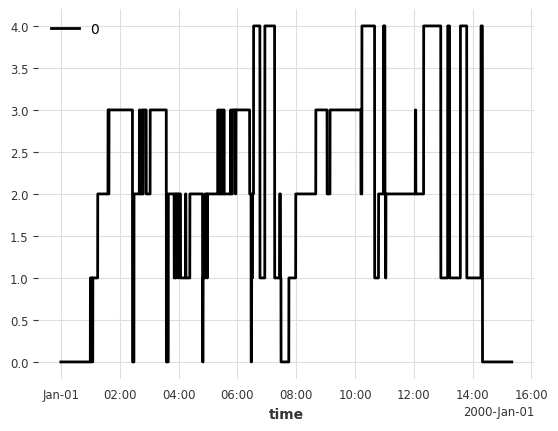

In [8]:
series[0].plot()

<Axes: xlabel='time'>

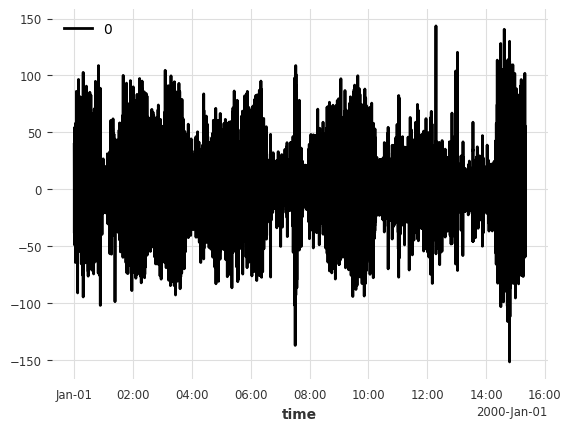

In [9]:
covs[0].plot()

In [10]:
len(series), len(covs)

(39, 39)

In [11]:
num_val = 4
num_test = 3

In [12]:
series_train, series_val, series_test = (
    series[: -(num_val + num_test)],
    series[-(num_val + num_test) : -num_test],
    series[-num_test:],
)
covs_train, covs_val, covs_test = (
    covs[: -(num_val + num_test)],
    covs[-(num_val + num_test) : -num_test],
    covs[-num_test:],
)

In [13]:
for cov in covs:
    print(cov.shape)

(55200, 1, 1)
(60960, 1, 1)
(57120, 1, 1)
(50460, 1, 1)
(63120, 1, 1)
(66240, 1, 1)
(61500, 1, 1)
(60180, 1, 1)
(63240, 1, 1)
(72000, 1, 1)
(50580, 1, 1)
(57840, 1, 1)
(60240, 1, 1)
(67620, 1, 1)
(58620, 1, 1)
(65520, 1, 1)
(60540, 1, 1)
(68040, 1, 1)
(68640, 1, 1)
(74100, 1, 1)
(66180, 1, 1)
(61680, 1, 1)
(76380, 1, 1)
(76440, 1, 1)
(105720, 1, 1)
(66300, 1, 1)
(106380, 1, 1)
(74760, 1, 1)
(55680, 1, 1)
(57120, 1, 1)
(71160, 1, 1)
(92100, 1, 1)
(58560, 1, 1)
(57120, 1, 1)
(60120, 1, 1)
(67920, 1, 1)
(40320, 1, 1)
(48120, 1, 1)
(54660, 1, 1)


<Axes: xlabel='time'>

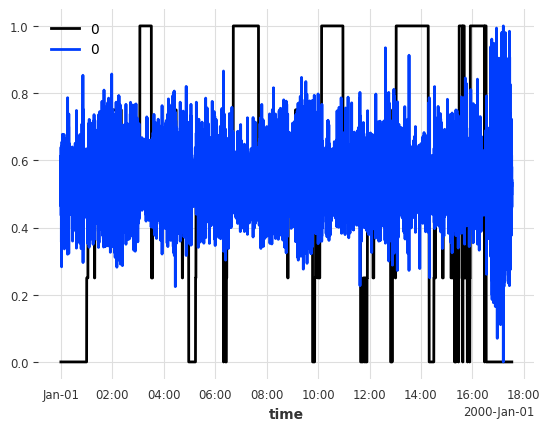

In [14]:
Scaler().fit_transform(series[4]).plot()
Scaler().fit_transform(covs[4]).plot()

In [15]:
model_cls = CatBoostClassifierModel

In [16]:
def n_hours_of_sleep(idx):
    return idx.hour

In [18]:
model = model_cls(
    lags=None,
    lags_future_covariates={
        "default_lags": (5, 1),
        "darts_enc_fc_cus_custom": [0],
    },
    output_chunk_length=1,
    use_static_covariates=True,
    add_encoders={"custom": {"future": [n_hours_of_sleep]}},
)

In [19]:
covs_train[0].shape, covs_val[0].shape

((55200, 1, 1), (58560, 1, 1))

In [20]:
model.fit(
    series=series_train,
    future_covariates=covs_train,
    val_series=series_val,
    val_future_covariates=covs_val,
)

CatBoostClassifierModel(lags=None, lags_past_covariates=None, lags_future_covariates={'default_lags': (5, 1), 'darts_enc_fc_cus_custom': [0]}, output_chunk_length=1, output_chunk_shift=0, add_encoders={'custom': {'future': [<function n_hours_of_sleep at 0x169cc4220>]}}, likelihood=classprobability, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [21]:
preds = model.historical_forecasts(
    series=series_test,
    future_covariates=covs_test,
    forecast_horizon=1,
    retrain=False,
    # predict_likelihood_parameters=True,
)

/Users/dennisbader/projects/unit8/darts/darts/utils/data/tabularization/tabularization.py:1720: UserWarning: `target_series` was specified without accompanying `lags` and, thus, will be ignored.
  warnings.warn(


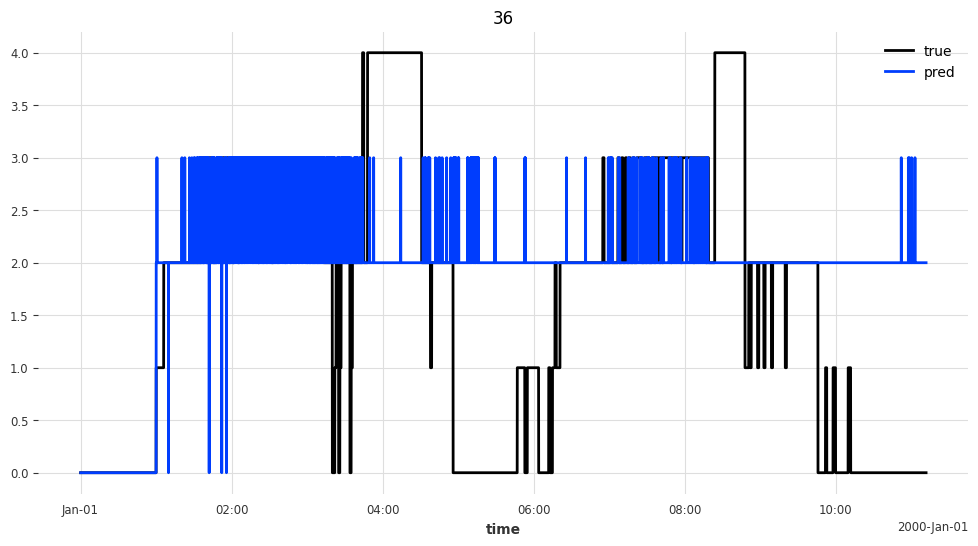

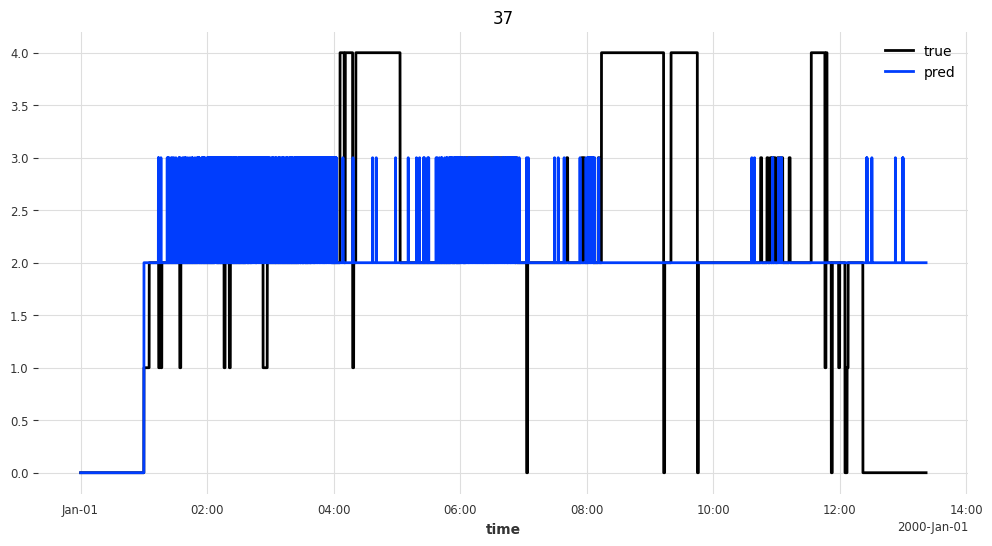

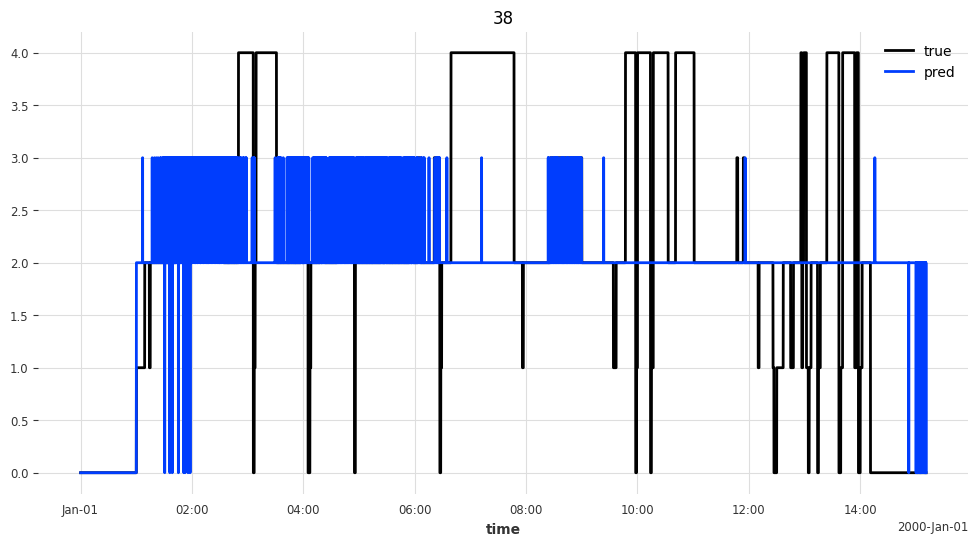

In [22]:
for s, p in zip(series_test, preds):
    fig, ax = plt.subplots(figsize=(12, 6))
    s.plot(label="true", ax=ax)
    p.plot(label="pred", ax=ax)
    ax.set_title(s.metadata["name"])
    plt.show()

In [23]:
y_true = []
y_pred = []
for s, p in zip(series_test, preds):
    y_true.append(s.slice_intersect(p).to_dataframe())
    y_pred.append(p.slice_intersect(s).to_dataframe())
y_true = pd.concat(y_true)
y_pred = pd.concat(y_pred)

In [24]:
(y_true == y_pred).mean()

component
0    0.533934
dtype: float64